class names: ['contempt' 'disgust' 'surprise' 'sadness' 'fear' 'anger' 'neutral'
 'happy']
54.0
num_train:1727, num_val:426, num_occ:427, num_test:427
(32, 160, 160, 3)
14/14 [==============================] - 2s 148ms/step - loss: 2.1490 - accuracy: 0.0869
initial loss: 2.15
initial accuracy: 0.09
Train for 54.0 steps, validate for 14 steps
Epoch 1/30
54/54 [==============================] - 13s 249ms/step - loss: 1.0145 - accuracy: 0.7690 - val_loss: 1.5899 - val_accuracy: 0.3568
Epoch 2/30
54/54 [==============================] - 6s 112ms/step - loss: 0.2053 - accuracy: 0.9600 - val_loss: 1.4689 - val_accuracy: 0.4296
Epoch 3/30
54/54 [==============================] - 6s 119ms/step - loss: 0.0610 - accuracy: 0.9873 - val_loss: 1.4056 - val_accuracy: 0.4812
Epoch 4/30
54/54 [==============================] - 6s 114ms/step - loss: 0.0325 - accuracy: 0.9919 - val_loss: 1.4720 - val_accuracy: 0.4953
Epoch 5/30
54/54 [==============================] - 7s 123ms/step - loss: 0.0213 - accu

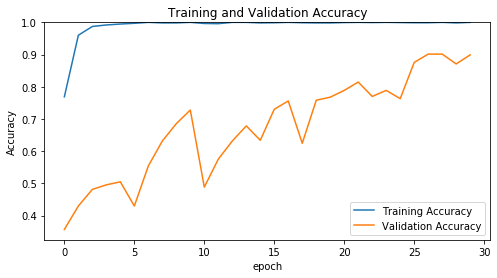

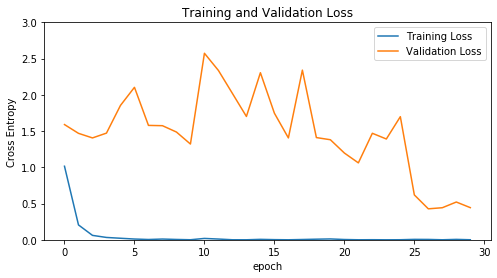

In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as display

import pathlib

from PIL import Image
#tf2.x
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

keras = tf.keras

#CLASS_NUM CAN BE SET TO 1 IF IT IS BINARY CLASSIFIER
CLASS_NUM = 8
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160

data_dir = '/data3/dongjy/CK+/CK_photos_train'
data_dir = pathlib.Path(data_dir)
num_train = len(list(data_dir.glob('*/*.jpg')))

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
print('class names:',CLASS_NAMES)
steps_per_epoch = np.ceil(num_train/BATCH_SIZE)
print(steps_per_epoch)

#???str(data_dir/'*/*')
train_list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

data_dir = '/data3/dongjy/CK+/original'
data_dir = pathlib.Path(data_dir)
num_val = len(list(data_dir.glob('*/*.png')))
val_list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

data_dir = '/data3/dongjy/CK+/occluded'
data_dir = pathlib.Path(data_dir)
num_occ = len(list(data_dir.glob('*/*.png')))
occ_list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

data_dir = '/data3/dongjy/CK+/generated'
data_dir = pathlib.Path(data_dir)
num_test = len(list(data_dir.glob('*/*.png')))
test_list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

print('num_train:{}, num_val:{}, num_occ:{}, num_test:{}'.format(num_train, num_val, num_occ, num_test))

#???zhe dou ok? parts[-2] == CLASS_NAMES 666
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = (img-0.5)*2
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path)
occ_ds = occ_list_ds.map(process_path)
test_ds = test_list_ds.map(process_path)

train_batches = train_ds.shuffle(1000).batch(BATCH_SIZE).repeat()
validation_batches = val_ds.batch(BATCH_SIZE)
test_batches = test_ds.batch(BATCH_SIZE)
occ_batches = occ_ds.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
  pass
print(image_batch.shape)

#for occ_img_batch, occ_lab_batch in occ_batches.take(1):
#  pass

#for test_img_batch, test_lab_batch in test_batches.take(1):
#  pass

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

feature_batch = base_model(image_batch)
#print(feature_batch.shape)

base_model.trainable = True

# Let's take a look at the base model architecture
#base_model.summary()


#convert the features to a single 1280-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

prediction_layer = keras.layers.Dense(CLASS_NUM,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

'''
predictions = model.predict(occ_batches)
pre = tf.argmax(predictions,1)
print(predictions,tf.shape(predictions),pre)
'''
#use categorical_crossentropy when the y_true is a one-hot vector
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

initial_epochs = 30
#steps_per_epoch = num_train//BATCH_SIZE
validation_steps = 20

#loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
loss0,accuracy0 = model.evaluate(validation_batches)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    steps_per_epoch=steps_per_epoch)

model.evaluate(occ_batches)
model.evaluate(test_batches)
#model.evaluate(occ_img_ds, occ_lab_ds)
#model.evaluate(test_img_ds, test_lab_ds)

model.predict(occ_batches)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('Accuracy.png')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('Loss.png')
plt.show()